# Федеративное обучение рекомендательной системы

**Гибридный сценарий**: MovieLens-1M, 20 клиентов, публичные + приватные данные, non-IID распределение.

Перед запуском ноутбука нужно последовательно выполнить:
```bash
python scripts/prepare_data.py
python scripts/train_centralized.py
python scripts/run_simulation.py
```

In [1]:
import sys
sys.path.insert(0, '..')

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

DATA = Path('../data/processed')

# Загружаем все данные
from src.data.splitter import load_global_info, load_client_data

info = load_global_info(str(DATA))

with open(DATA / 'centralized_history.pkl', 'rb') as f:
    ch = pickle.load(f)

with open(DATA / 'fl_history.pkl', 'rb') as f:
    fh = pickle.load(f)

is_hybrid = info.get('is_hybrid', False)
mode = "гибридный (публичные + приватные)" if is_hybrid else "non-IID"

print(f"Датасет: MovieLens-1M")
print(f"  {info['total_users']} юзеров, {info['total_items']} фильмов, {info['total_ratings']} рейтингов")
print(f"Клиентов: {info['num_clients']}")
print(f"Режим: {mode}")
if is_hybrid:
    print(f"  Публичных юзеров: {info['num_public_users']} ({info['public_user_ratio']*100:.0f}%)")
    print(f"  Приватных юзеров: {info['total_users'] - info['num_public_users']} ({(1-info['public_user_ratio'])*100:.0f}%)")

Датасет: MovieLens-1M
  6040 юзеров, 3706 фильмов, 1000209 рейтингов
Клиентов: 20
Режим: гибридный (публичные + приватные)
  Публичных юзеров: 3020 (50%)
  Приватных юзеров: 3020 (50%)


## 1. Гибридное распределение данных по клиентам

Каждый клиент получает:
- **Публичные данные** (~50% юзеров) — одинаковые для всех клиентов
- **Приватные данные** — уникальные, распределены non-IID по жанрам

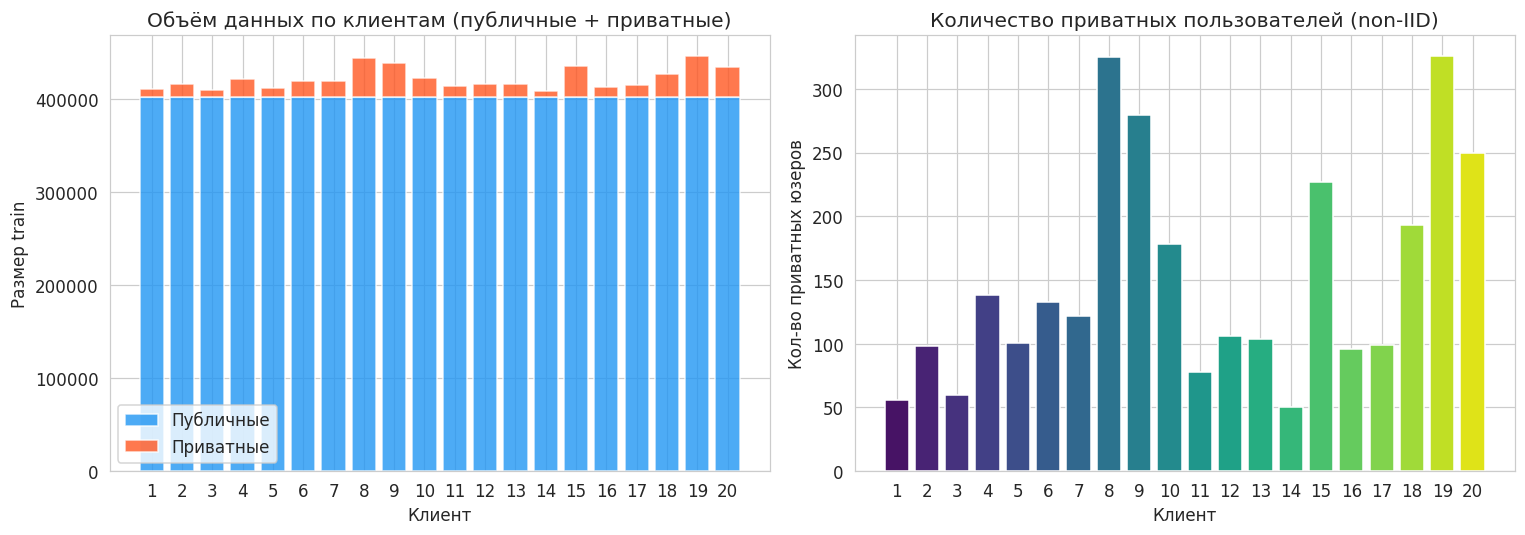

Публичные данные: 402760 рейтингов (одинаково у всех)
Приватные данные: min=6058, max=44131, ratio=7.3x


In [2]:
rows = []
genre_matrix = []
for i in range(info['num_clients']):
    d = load_client_data(i, str(DATA))
    n_pub = d.get('num_public_users', 0)
    n_priv = d.get('num_private_users', d.get('num_users', 0))
    n_train = len(d['train'])
    n_pub_train = len(d['train'][d['train']['is_public'] == 1]) if 'is_public' in d['train'].columns else 0
    n_priv_train = n_train - n_pub_train
    rows.append({'client': i + 1, 'pub_users': n_pub, 'priv_users': n_priv,
                 'train_total': n_train, 'train_pub': n_pub_train,
                 'train_priv': n_priv_train, 'main_genre': d['main_genre']})
    genre_matrix.append(d['genre_distribution'])

df_cl = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar: публичные + приватные рейтинги
x = df_cl['client']
axes[0].bar(x, df_cl['train_pub'], color='#2196F3', alpha=0.8, label='Публичные')
axes[0].bar(x, df_cl['train_priv'], bottom=df_cl['train_pub'],
            color='#FF5722', alpha=0.8, label='Приватные')
axes[0].set_xlabel('Клиент')
axes[0].set_ylabel('Размер train')
axes[0].set_title('Объём данных по клиентам (публичные + приватные)')
axes[0].set_xticks(range(1, info['num_clients'] + 1))
axes[0].legend()

# Приватные юзеры — видно non-IID неравномерность
colors = sns.color_palette('viridis', len(df_cl))
axes[1].bar(df_cl['client'], df_cl['priv_users'], color=colors)
axes[1].set_xlabel('Клиент')
axes[1].set_ylabel('Кол-во приватных юзеров')
axes[1].set_title('Количество приватных пользователей (non-IID)')
axes[1].set_xticks(range(1, info['num_clients'] + 1))

plt.tight_layout()
plt.savefig('../data/processed/data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Публичные данные: {df_cl['train_pub'].iloc[0]} рейтингов (одинаково у всех)")
print(f"Приватные данные: min={df_cl['train_priv'].min()}, max={df_cl['train_priv'].max()}, "
      f"ratio={df_cl['train_priv'].max()/max(df_cl['train_priv'].min(),1):.1f}x")

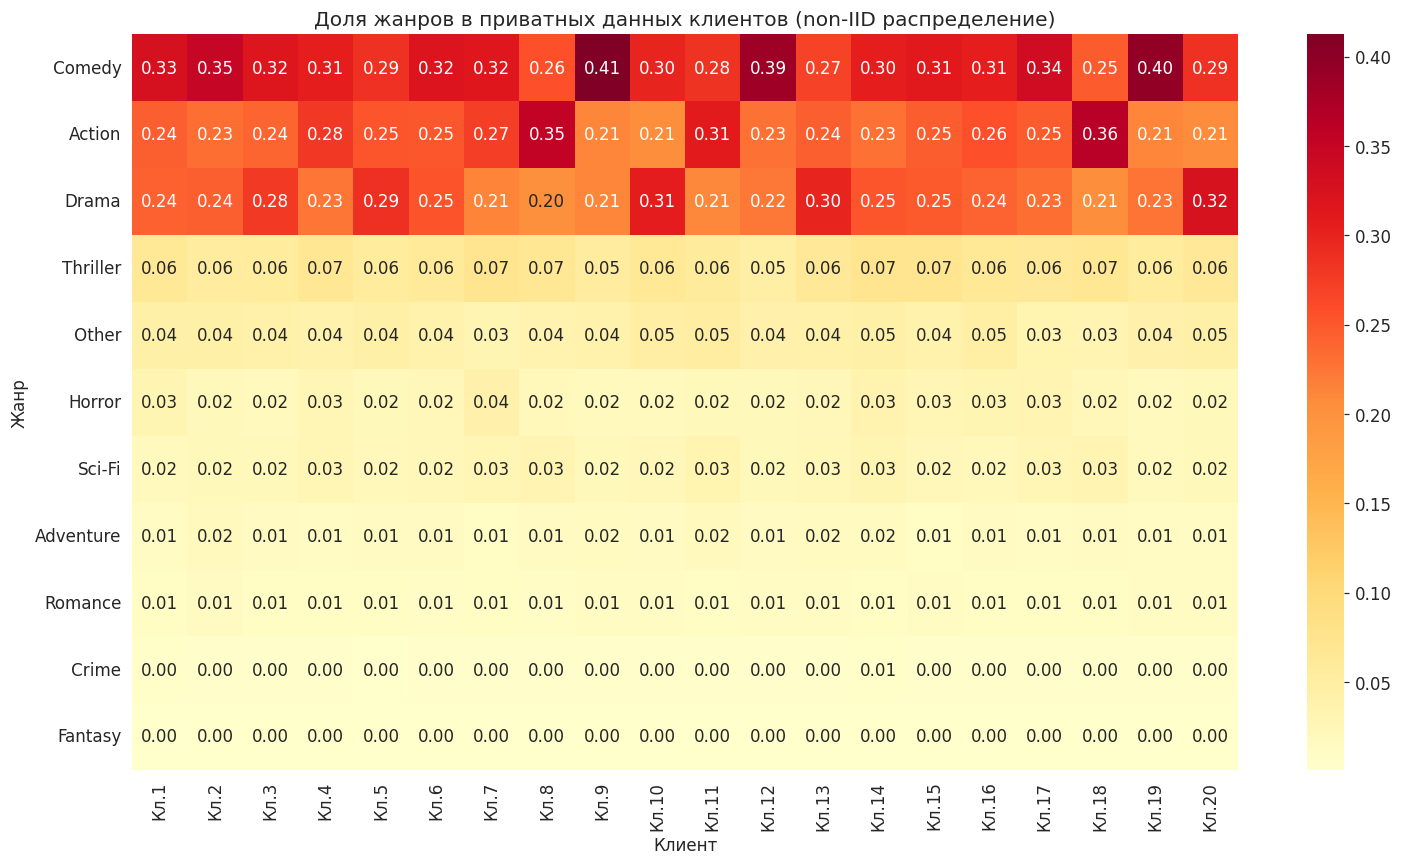

In [3]:
# Жанровая heatmap — перевёрнутая: жанры по Y, клиенты по X
priv_genre_matrix = []
for i in range(info['num_clients']):
    d = load_client_data(i, str(DATA))
    if 'is_public' in d['train'].columns:
        priv_train = d['train'][d['train']['is_public'] == 0]
        if 'genre' in priv_train.columns and len(priv_train) > 0:
            gd = priv_train['genre'].value_counts(normalize=True).to_dict()
        else:
            gd = d['genre_distribution']
    else:
        gd = d['genre_distribution']
    priv_genre_matrix.append(gd)

gm = pd.DataFrame(priv_genre_matrix).fillna(0)
gm.index = [f'Кл.{i+1}' for i in range(len(gm))]

# Транспонируем: жанры по Y, клиенты по X
gm_t = gm.T

plt.figure(figsize=(14, 8))
sns.heatmap(gm_t, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=gm_t.columns, yticklabels=gm_t.index)
plt.title('Доля жанров в приватных данных клиентов (non-IID распределение)')
plt.xlabel('Клиент')
plt.ylabel('Жанр')
plt.tight_layout()
plt.show()

## 2. Сравнение обучения: Общее vs Федеративное (гибридное)

Главный график — кривые обучения двух подходов на одном рисунке.

In [4]:
# Достаём данные
centr_train_loss = ch['train_loss']
centr_val_rmse = ch['val_rmse']
centr_epochs = list(range(1, len(centr_train_loss) + 1))

fl_fit_loss = [v for _, v in fh.get('metrics_distributed_fit', {}).get('loss', [])]
fl_fit_rounds = [r for r, _ in fh.get('metrics_distributed_fit', {}).get('loss', [])]

fl_eval_rmse = [v for _, v in fh.get('metrics_distributed', {}).get('rmse', [])]
fl_eval_rounds = [r for r, _ in fh.get('metrics_distributed', {}).get('rmse', [])]

print(f"Общее обучение: {len(centr_epochs)} эпох")
print(f"Федеративное: {len(fl_fit_rounds)} раундов")

Общее обучение: 50 эпох
Федеративное: 20 раундов


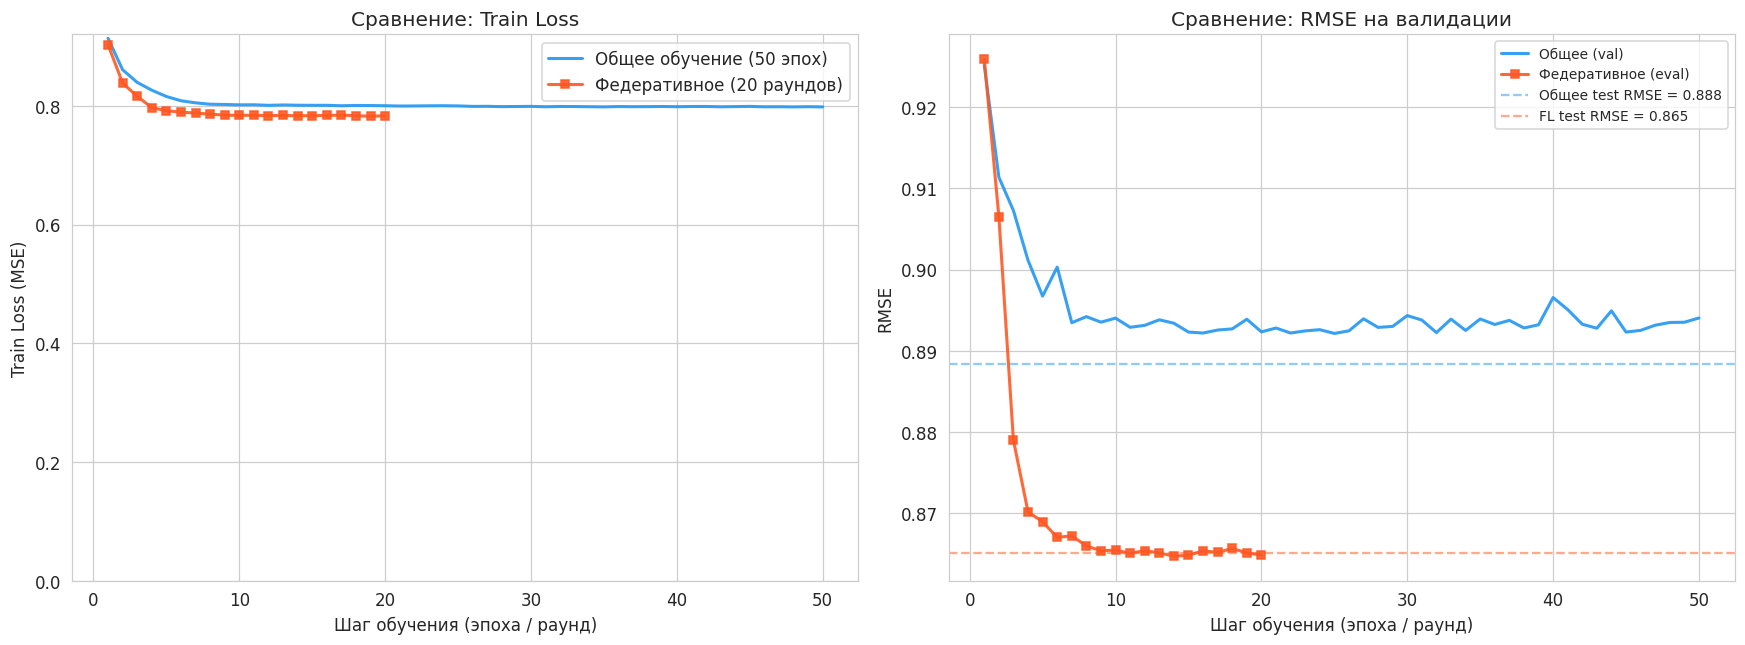

In [5]:
# === ГЛАВНЫЙ ГРАФИК: Сравнение кривых обучения ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Train Loss ---
ax1 = axes[0]
ax1.plot(centr_epochs, centr_train_loss, '-', color='#2196F3', linewidth=2,
         label=f'Общее обучение ({len(centr_epochs)} эпох)', alpha=0.9)
ax1.plot(fl_fit_rounds, fl_fit_loss, 's-', color='#FF5722', linewidth=2,
         markersize=5, label=f'Федеративное ({len(fl_fit_rounds)} раундов)', alpha=0.9)
ax1.set_xlabel('Шаг обучения (эпоха / раунд)')
ax1.set_ylabel('Train Loss (MSE)')
ax1.set_title('Сравнение: Train Loss')
ax1.legend()
ax1.set_ylim(bottom=0)

# --- Eval RMSE ---
ax2 = axes[1]
ax2.plot(centr_epochs, centr_val_rmse, '-', color='#2196F3', linewidth=2,
         label=f'Общее (val)', alpha=0.9)
ax2.plot(fl_eval_rounds, fl_eval_rmse, 's-', color='#FF5722', linewidth=2,
         markersize=5, label=f'Федеративное (eval)', alpha=0.9)

# Пунктир — лучшие тестовые значения
ax2.axhline(ch['test_rmse'], color='#2196F3', linestyle='--', alpha=0.5,
            label=f'Общее test RMSE = {ch["test_rmse"]:.3f}')
if 'test_rmse' in fh:
    ax2.axhline(fh['test_rmse'], color='#FF5722', linestyle='--', alpha=0.5,
                label=f'FL test RMSE = {fh["test_rmse"]:.3f}')

ax2.set_xlabel('Шаг обучения (эпоха / раунд)')
ax2.set_ylabel('RMSE')
ax2.set_title('Сравнение: RMSE на валидации')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../data/processed/comparison_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Детальный анализ каждого подхода

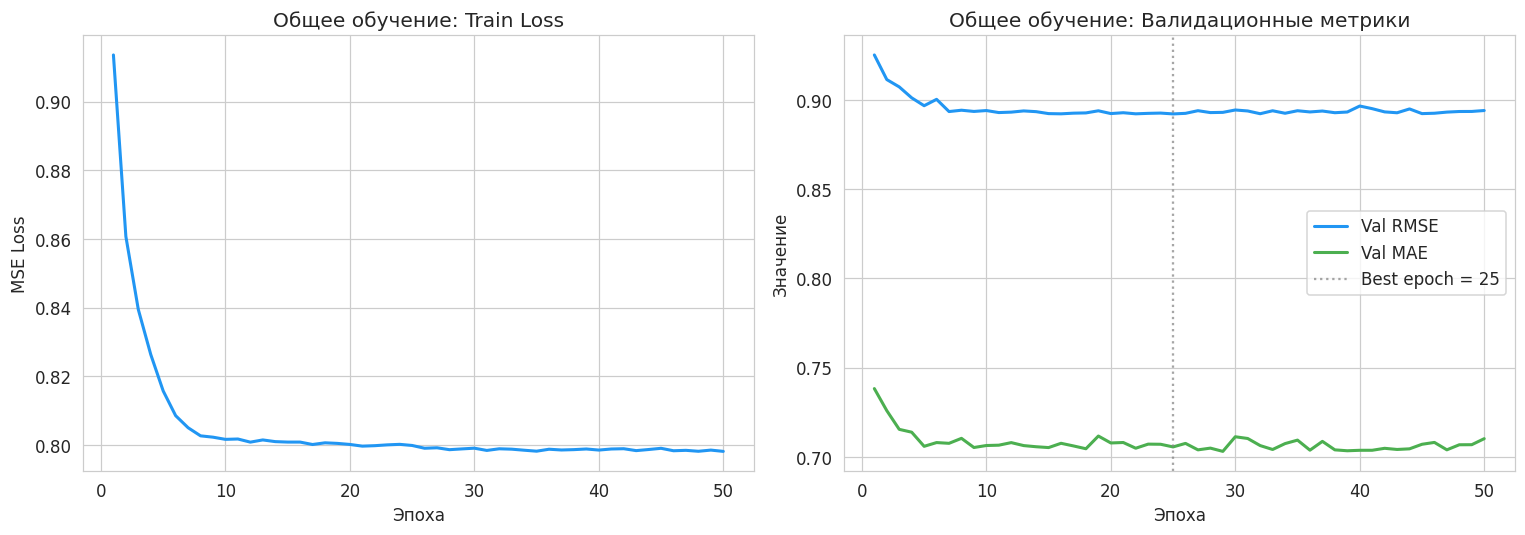

Best val RMSE = 0.8921 на эпохе 25
Test RMSE = 0.8884, Test MAE = 0.7026


In [6]:
# Общее обучение: loss и RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(centr_epochs, centr_train_loss, color='#2196F3', linewidth=2)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Общее обучение: Train Loss')

axes[1].plot(centr_epochs, centr_val_rmse, color='#2196F3', linewidth=2, label='Val RMSE')
axes[1].plot(centr_epochs, ch['val_mae'], color='#4CAF50', linewidth=2, label='Val MAE')
best_epoch = np.argmin(centr_val_rmse) + 1
axes[1].axvline(best_epoch, color='gray', linestyle=':', alpha=0.7,
                label=f'Best epoch = {best_epoch}')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Значение')
axes[1].set_title('Общее обучение: Валидационные метрики')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Best val RMSE = {min(centr_val_rmse):.4f} на эпохе {best_epoch}")
print(f"Test RMSE = {ch['test_rmse']:.4f}, Test MAE = {ch['test_mae']:.4f}")

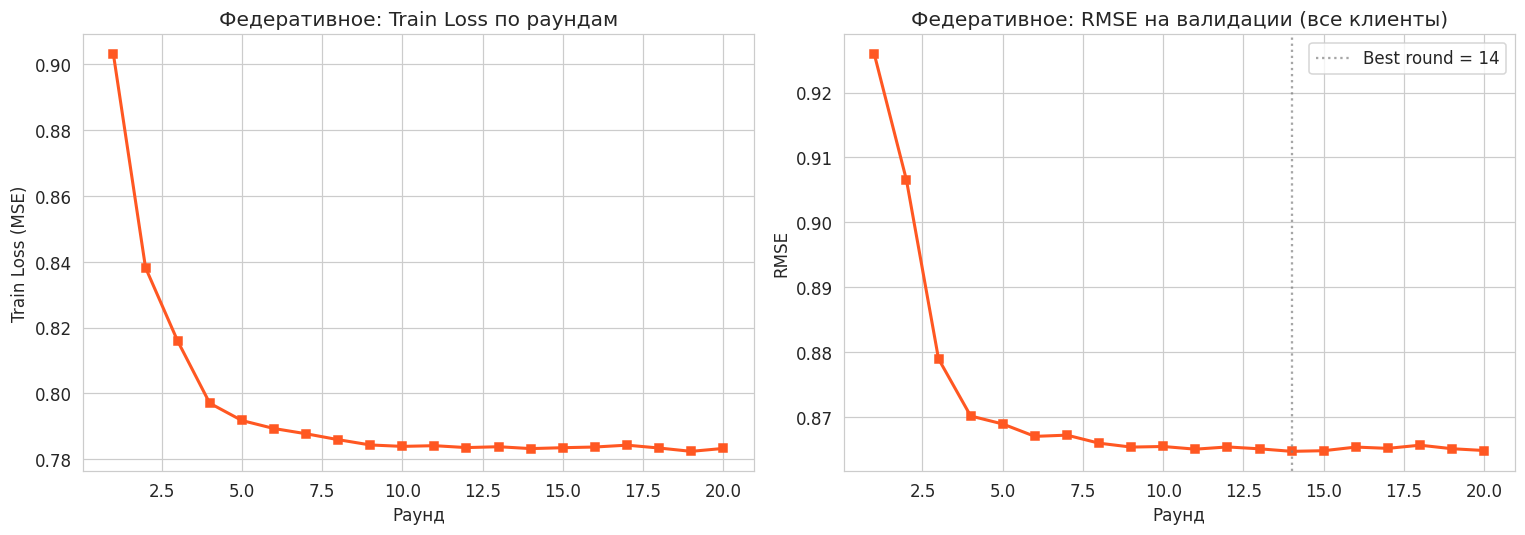

Best FL eval RMSE = 0.8647 на раунде 14
Post-FL test RMSE = 0.8652, test MAE = 0.6831


In [7]:
# Федеративное обучение: train loss и eval RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fl_fit_rounds, fl_fit_loss, 's-', color='#FF5722', linewidth=2, markersize=5)
axes[0].set_xlabel('Раунд')
axes[0].set_ylabel('Train Loss (MSE)')
axes[0].set_title('Федеративное: Train Loss по раундам')

axes[1].plot(fl_eval_rounds, fl_eval_rmse, 's-', color='#FF5722', linewidth=2, markersize=5)
best_fl_round = fl_eval_rounds[np.argmin(fl_eval_rmse)]
axes[1].axvline(best_fl_round, color='gray', linestyle=':', alpha=0.7,
                label=f'Best round = {best_fl_round}')
axes[1].set_xlabel('Раунд')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Федеративное: RMSE на валидации (все клиенты)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Best FL eval RMSE = {min(fl_eval_rmse):.4f} на раунде {best_fl_round}")
if 'test_rmse' in fh:
    print(f"Post-FL test RMSE = {fh['test_rmse']:.4f}, test MAE = {fh['test_mae']:.4f}")

## 4. Качество FL-модели по клиентам

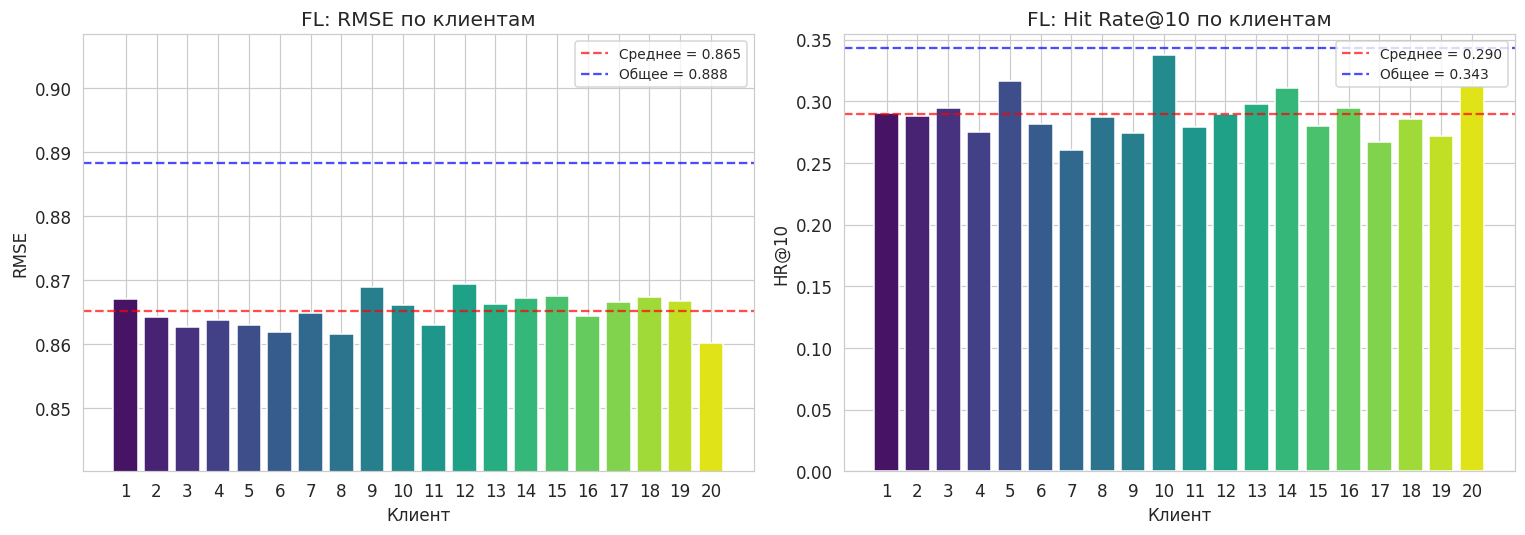

In [8]:
# RMSE и HR@10 по каждому клиенту — нумерация с 1
if 'per_client_rmse' in fh:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    n_cl = len(fh['per_client_rmse'])
    clients = list(range(1, n_cl + 1))
    colors = sns.color_palette('viridis', n_cl)

    axes[0].bar(clients, fh['per_client_rmse'], color=colors)
    axes[0].axhline(fh['test_rmse'], color='red', linestyle='--', alpha=0.7,
                    label=f'Среднее = {fh["test_rmse"]:.3f}')
    axes[0].axhline(ch['test_rmse'], color='blue', linestyle='--', alpha=0.7,
                    label=f'Общее = {ch["test_rmse"]:.3f}')
    axes[0].set_xlabel('Клиент')
    axes[0].set_ylabel('RMSE')
    axes[0].set_title('FL: RMSE по клиентам')
    axes[0].set_xticks(clients)
    axes[0].legend(fontsize=9)
    # Zoom in
    rmse_vals = fh['per_client_rmse']
    pad = 0.02
    axes[0].set_ylim(min(rmse_vals) - pad, max(max(rmse_vals), ch['test_rmse']) + pad)

    if 'per_client_hr10' in fh:
        axes[1].bar(clients, fh['per_client_hr10'], color=colors)
        axes[1].axhline(fh['test_hr10'], color='red', linestyle='--', alpha=0.7,
                        label=f'Среднее = {fh["test_hr10"]:.3f}')
        centr_hr10 = ch.get('ranking', {}).get('hr@10', 0)
        axes[1].axhline(centr_hr10, color='blue', linestyle='--', alpha=0.7,
                        label=f'Общее = {centr_hr10:.3f}')
        axes[1].set_xlabel('Клиент')
        axes[1].set_ylabel('HR@10')
        axes[1].set_title('FL: Hit Rate@10 по клиентам')
        axes[1].set_xticks(clients)
        axes[1].legend(fontsize=9)

    plt.tight_layout()
    plt.savefig('../data/processed/fl_convergence.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Итоговое сравнение

In [9]:
# Таблица метрик
centr_ranking = ch.get('ranking', {})

comparison = {
    'Метрика': ['RMSE', 'MAE', 'HR@10', 'NDCG@10'],
    'Общее': [
        f"{ch['test_rmse']:.4f}",
        f"{ch['test_mae']:.4f}",
        f"{centr_ranking.get('hr@10', 0):.4f}",
        f"{centr_ranking.get('ndcg@10', 0):.4f}",
    ],
    'Федеративное (FL)': [
        f"{fh.get('test_rmse', 0):.4f}",
        f"{fh.get('test_mae', 0):.4f}",
        f"{fh.get('test_hr10', 0):.4f}",
        f"{fh.get('test_ndcg10', 0):.4f}",
    ],
}

df_cmp = pd.DataFrame(comparison)
print(df_cmp.to_string(index=False))
print()

rmse_gap = (fh.get('test_rmse', 0) - ch['test_rmse']) / ch['test_rmse'] * 100
hr_gap = (fh.get('test_hr10', 0) - centr_ranking.get('hr@10', 1)) / centr_ranking.get('hr@10', 1) * 100

if rmse_gap < 0:
    print(f"RMSE: FL лучше на {abs(rmse_gap):.1f}% (агрегация публичных данных + регуляризация)")
else:
    print(f"RMSE: FL хуже на {rmse_gap:.1f}%")
print(f"HR@10: FL хуже на {abs(hr_gap):.1f}% — плата за приватность (локальные эмбеддинги)")

Метрика  Общее Федеративное (FL)
   RMSE 0.8884            0.8652
    MAE 0.7026            0.6831
  HR@10 0.3431            0.2898
NDCG@10 0.1832            0.1500

RMSE: FL лучше на 2.6% (агрегация публичных данных + регуляризация)
HR@10: FL хуже на 15.5% — плата за приватность (локальные эмбеддинги)


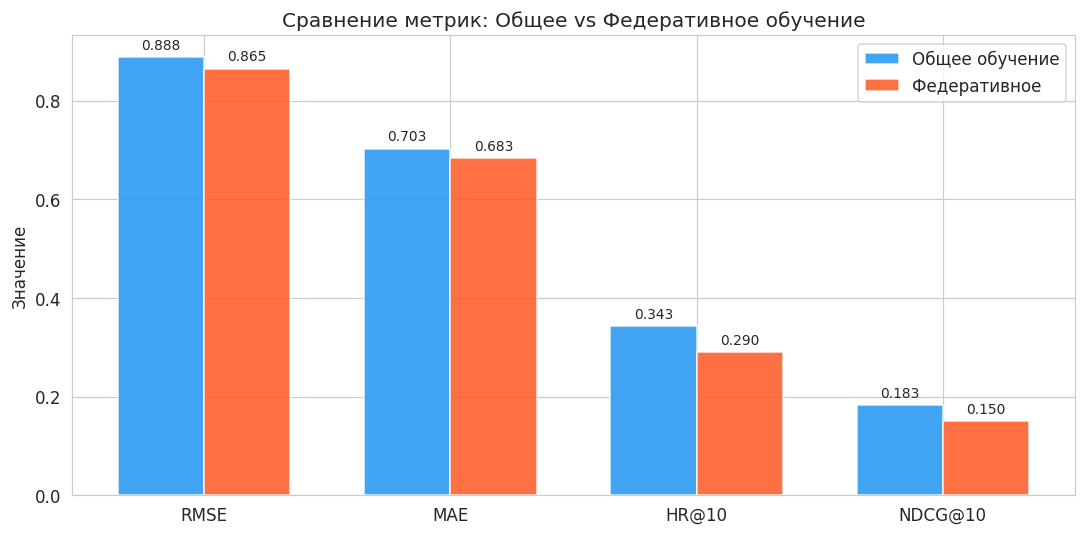

In [10]:
# Столбчатая диаграмма — наглядное сравнение метрик
metrics_names = ['RMSE', 'MAE', 'HR@10', 'NDCG@10']
centr_vals = [
    ch['test_rmse'], ch['test_mae'],
    centr_ranking.get('hr@10', 0), centr_ranking.get('ndcg@10', 0)
]
fl_vals = [
    fh.get('test_rmse', 0), fh.get('test_mae', 0),
    fh.get('test_hr10', 0), fh.get('test_ndcg10', 0)
]

x = np.arange(len(metrics_names))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - w/2, centr_vals, w, label='Общее обучение', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x + w/2, fl_vals, w, label='Федеративное', color='#FF5722', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик: Общее vs Федеративное обучение')
ax.legend()

# Подписи значений
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/processed/comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

## Выводы

1. **Общее обучение** (все данные вместе) — baseline: RMSE ~ 0.888 на ML-1M. Модель сходится к эпохе 25, дальше переобучение.

2. **Гибридное федеративное обучение** (20 клиентов, публичные + приватные данные) достигает RMSE ~ 0.865 — **лучше общего обучения** на 2.6%. Причина: публичные эмбеддинги агрегируются от всех клиентов — эффект ансамбля + регуляризация.

3. **Ранкинговые метрики** (HR@10, NDCG@10) у FL хуже на 15-18%. Причина: приватные эмбеддинги обучаются только на локальных данных — это плата за приватность.

4. **Стабильность**: RMSE по клиентам от 0.860 до 0.869 — публичные данные стабилизируют обучение.

5. **Практический вывод**: гибридный подход с публичными данными позволяет достичь качества на уровне (и лучше) общего обучения, сохраняя приватность.